In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [3]:
train_dir = './train/'
test_dir = './test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise   sad  happy  angry
train      3171  4830   7215   3995
      surprise   sad  happy  angry
test       831  1247   1774    958


In [1]:
!unzip new.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: train/sad/Training_65242339.jpg  
 extracting: train/sad/Training_65267116.jpg  
 extracting: train/sad/Training_65275626.jpg  
 extracting: train/sad/Training_6529266.jpg  
 extracting: train/sad/Training_65329617.jpg  
 extracting: train/sad/Training_65338712.jpg  
 extracting: train/sad/Training_65338797.jpg  
 extracting: train/sad/Training_65387162.jpg  
 extracting: train/sad/Training_65404494.jpg  
 extracting: train/sad/Training_65426218.jpg  
 extracting: train/sad/Training_65430136.jpg  
 extracting: train/sad/Training_65437377.jpg  
 extracting: train/sad/Training_6545735.jpg  
 extracting: train/sad/Training_65463385.jpg  
 extracting: train/sad/Training_65473985.jpg  
 extracting: train/sad/Training_65502829.jpg  
 extracting: train/sad/Training_65505359.jpg  
 extracting: train/sad/Training_65508578.jpg  
 extracting: train/sad/Training_65516023.jpg  
 extracting: train/sad/Training_65524027.jpg  
 extracting: train/sad/Tra

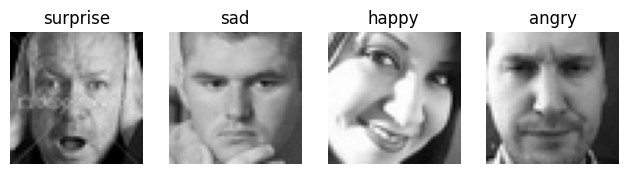

In [4]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
print(training_set.class_indices)
validation_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')
print(test_set.class_indices)

Found 15369 images belonging to 4 classes.
{'angry': 0, 'happy': 1, 'sad': 2, 'surprise': 3}
Found 3842 images belonging to 4 classes.
Found 4810 images belonging to 4 classes.
{'angry': 0, 'happy': 1, 'sad': 2, 'surprise': 3}


In [9]:
weight_decay = 1e-4

num_classes = 4

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        1088      
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_5 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        65600     
                                                                 
 activation_7 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                     

In [10]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

In [11]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=200,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/200
240/240 [==============================] - ETA: 0s - loss: 1.3802 - accuracy: 0.4593
Epoch 1: val_accuracy improved from -inf to 0.26406, saving model to model.weights.best.hdf5
240/240 [==============================] - 20s 57ms/step - loss: 1.3802 - accuracy: 0.4593 - val_loss: 2.5253 - val_accuracy: 0.2641


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
240/240 [==============================] - ETA: 0s - loss: 1.0610 - accuracy: 0.5571
Epoch 2: val_accuracy improved from 0.26406 to 0.51693, saving model to model.weights.best.hdf5
240/240 [==============================] - 13s 55ms/step - loss: 1.0610 - accuracy: 0.5571 - val_loss: 1.1952 - val_accuracy: 0.5169
Epoch 3/200
239/240 [============================>.] - ETA: 0s - loss: 0.9589 - accuracy: 0.6127
Epoch 3: val_accuracy improved from 0.51693 to 0.61979, saving model to model.weights.best.hdf5
240/240 [==============================] - 13s 56ms/step - loss: 0.9589 - accuracy: 0.6129 - val_loss: 0.9371 - val_accuracy: 0.6198
Epoch 4/200
239/240 [============================>.] - ETA: 0s - loss: 0.8794 - accuracy: 0.6492
Epoch 4: val_accuracy did not improve from 0.61979
240/240 [==============================] - 13s 55ms/step - loss: 0.8785 - accuracy: 0.6498 - val_loss: 1.0268 - val_accuracy: 0.6180
Epoch 5/200
240/240 [==============================] - ETA: 0s - lo

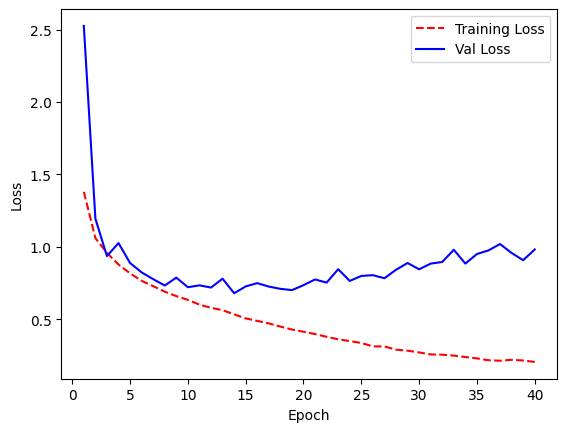

In [12]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

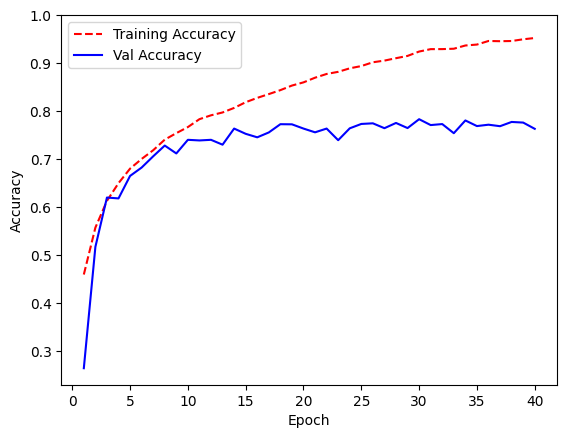

In [13]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()


In [14]:
# saving the model
model.save("fer_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

75/75 [==============================] - 2s 25ms/step - loss: 0.8011 - accuracy: 0.7921
Test accuracy = 79.20833230018616%
